In [13]:
 def model_columns():
    columns = ['Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario','Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo','Generacion_programada_P48_Enlace_Baleares','Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hulla_antracita','Generacion_programada_P48_Hulla_sub-bituminosa','Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica','Generacion_programada_P48_Turbinacion_bombeo','IBEX35',
                 'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 'Weekday_Friday', 'Weekday_Saturday', 'holidays',
                 'Hour_0', 'Hour_1', 'Hour_2',
                 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 'Hour_22','Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11','Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']
    return columns

def dummy_df(df=None,variables=['Weekday','Hour','day','month','year']):
    """
    With this function we are going to create dummy variables for those categorical variables we are using in our model. 
    Furthermore, we are going to create also dummy variables for the hour, day, month, etc. in our model in order to give the same 
    relevance to each of the values.
    """
    import pandas as pd
    # We read the dataframe in case we don't pass any:
    if df is None:
        df = pd.read_csv('../Models/final_dataframe.csv',index_col='datetime')
    else:
        df
        
    # We select the columns to "dummify":
    for var in variables:
        df = pd.concat([df,pd.get_dummies(df[var], prefix=var)],axis=1)
    # now drop the original 'Weekday' column (you don't need it anymore)
    df.drop(variables,axis=1, inplace=True)
    return df

def forecasting_function(df=dummy_df(),days=7, target='Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'):
    """
    With this function we are going to move the target variable a number of periods we decide to forecast. The number of 
    periods must be in concordance with the time unit we are using in our dataframe. For this case, we are predicting hourly 
    values, and we want to predict the values for the next week so:
    24 x 7 = 168. Our period must be 168.
    """
    # First we move the target variable:
    df[target]=df[target].shift(-24*days)
    # Then we eliminate the last rows:
    df.dropna(axis=0,how='any',inplace=True)
    return df

def regression_prediction(df=None,columns = model_columns(), target = 'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    from sklearn.model_selection import GridSearchCV, train_test_split
    # We read the dataframe in case we don't pass any:
    if df is None:
        df = forecasting_function()
    else:
        df
    
    # We split the data:
    X = df.loc[:,columns]
    y = df.loc[:,target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)
    
    # Then initialize the xgboos model:
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 40, early_stopping_rounds =10)

    parameters = {'colsample_bytree':[0.4,0.3,0.25,0.2],'learning_rate': [0.05,0.1,0.15,0.2],
                    'max_depth': [5,7,9]}

    xgb_mod = GridSearchCV(xg_reg,cv=10,verbose=1,param_grid=parameters,
                           scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')
    
    xgb_mod.fit(X_train,y_train)
    
    xgb_mod.best_estimator_.fit(X_train,y_train)
    
    y_pred = xgb_mod.best_estimator_.predict(X_test)
    
    return y_test,y_pred

def neural_network_prediction(df=None, columns = model_columns(), target = 'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'):
    import pandas as pd
    import numpy as np
    import tensorflow.keras as keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.layers import Dropout
    from sklearn.preprocessing import MinMaxScaler
    
    if df is None:
        df = forecasting_function()
    else:
        df
    
    X = df.loc[:,columns]
    y = df.loc[:,target]
    y_train_aux = y.loc[:'2019-06-01 00:00:00+00:00',]
    X_train_aux = X.loc[:'2019-06-01 00:00:00+00:00',columns]
    y_test_aux = y.loc['2019-06-01 00:00:00+00:00':,]
    X_test_aux = X.loc['2019-06-01 00:00:00+00:00':,columns]

    X_train = X_train_aux.values
    y_train = y_train_aux.values
    X_test = X_test_aux.values
    y_test = y_test_aux.values

    # Normalizamos:
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    #reshape y:
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    y_train = scaler.fit_transform(y_train)
    X_test = scaler.fit_transform(X_test)
    y_test = scaler.fit_transform(y_test)
    # Habrá que hacer un reshape para formatearlos para que entren en la red neuronal:
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='RMSprop')
    # fit network
    history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)    
    # make a prediction
    yhat = model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    y_test = y_test.reshape((len(y_test), 1))
    inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    return y_test,inv_y
    
def time_series_prediction(df=None, columns = model_columns(), target = 'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'):
    from fbprophet import Prophet
    
    if df is None:
        df = forecasting_function()
    else:
        df
        
    new_df = df.reset_index()[['datetime',target]]
    new_df.columns= ['ds','y']
    new_df.ds = pd.to_datetime(new_df.ds)
    new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")

    train = new_df[new_df['ds']<'2020-01-01 00:00:00']
    test = new_df[new_df['ds']>='2020-01-01 00:00:00']
    
    m = Prophet()
    m.fit(train)
    
    forecast = m.predict(test[['ds']])
    
    return test['y'],forecast['yhat']

def RMSE_metric(y_pred,y_hat):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(y_test, y_pred))

def R2_metric(y_pred,y_hat):
    from sklearn.metrics import r2_score
    return r2_score(y_test, y_pred)
    
def plot_predictions(y_test,y_pred):
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [50, 25]
    plt.plot(y_test, label='test')
    plt.plot(y_pred, label='pred')
    plt.legend()
    return plt.show()

In [3]:
y_reg, y_pred_reg = regression_prediction()

/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  5.2min finished


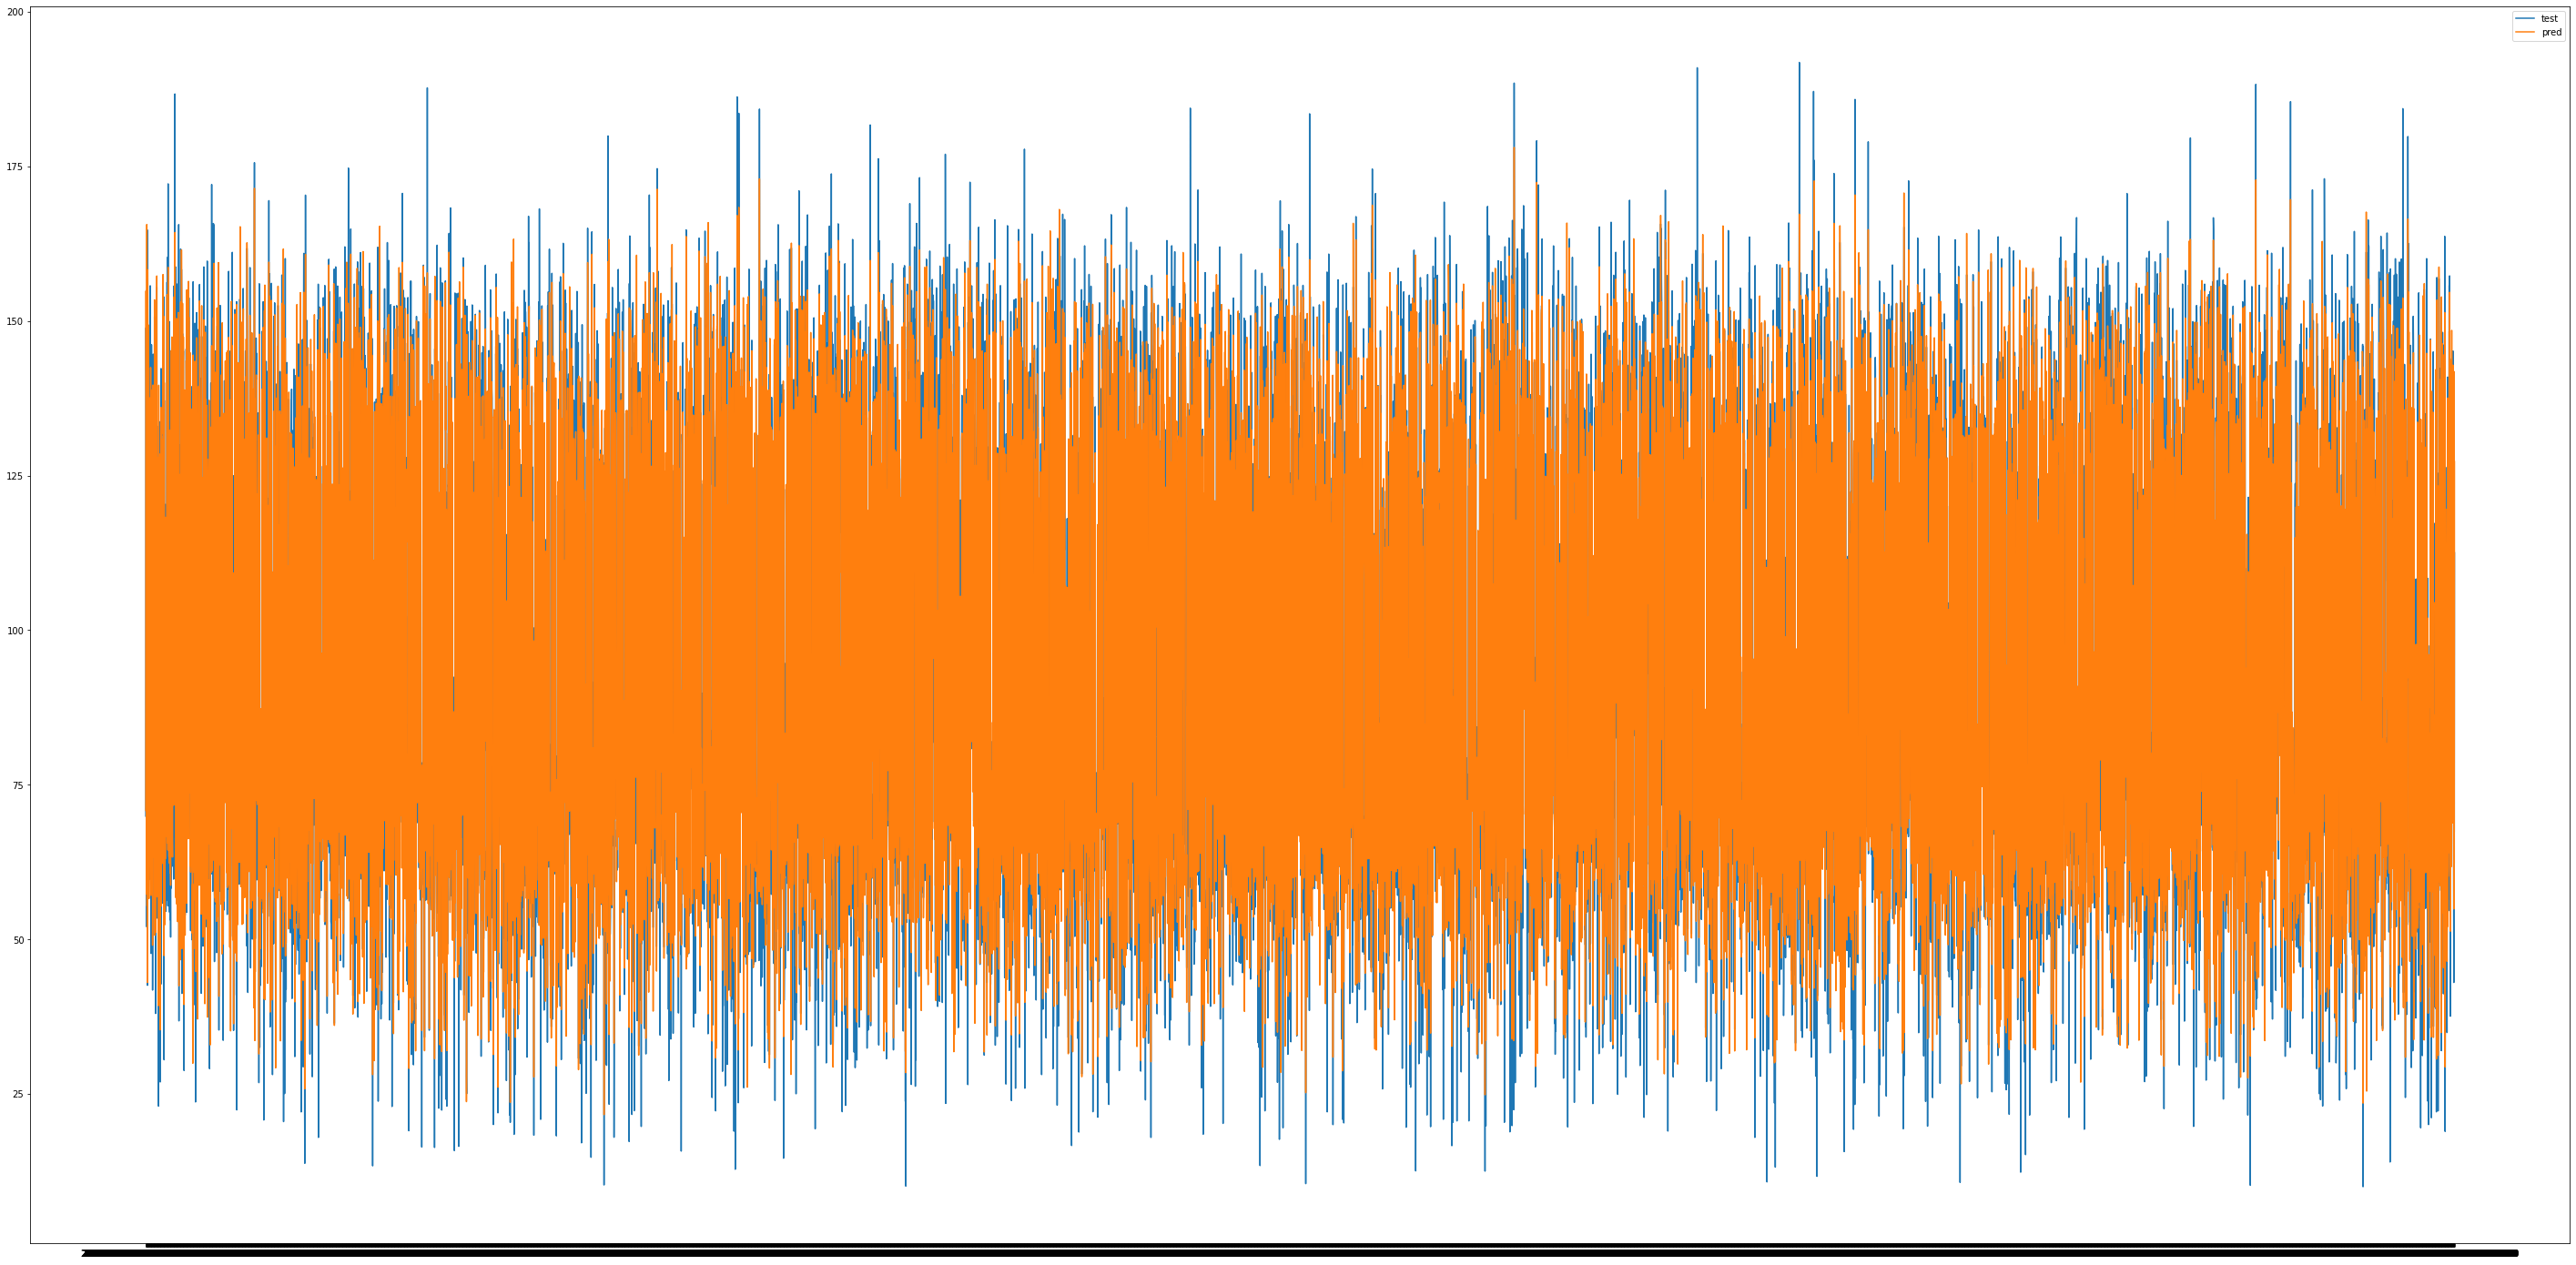

In [12]:
plot_predictions(y_reg,y_pred_reg)

In [17]:
y_neu, y_pred_neu = neural_network_prediction()

/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/joeldela/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/joeldela/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/joeldela/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/joeldela/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN 

Epoch 1/50
453/453 - 2s - loss: nan - val_loss: nan
Epoch 2/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 3/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 4/50
453/453 - 2s - loss: nan - val_loss: nan
Epoch 5/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 6/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 7/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 8/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 9/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 10/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 11/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 12/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 13/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 14/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 15/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 16/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 17/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 18/50
453/453 - 1s - loss: nan - val_loss: nan
Epoch 19/50
453/453 - 1s - loss: nan - val_loss: nan
Ep

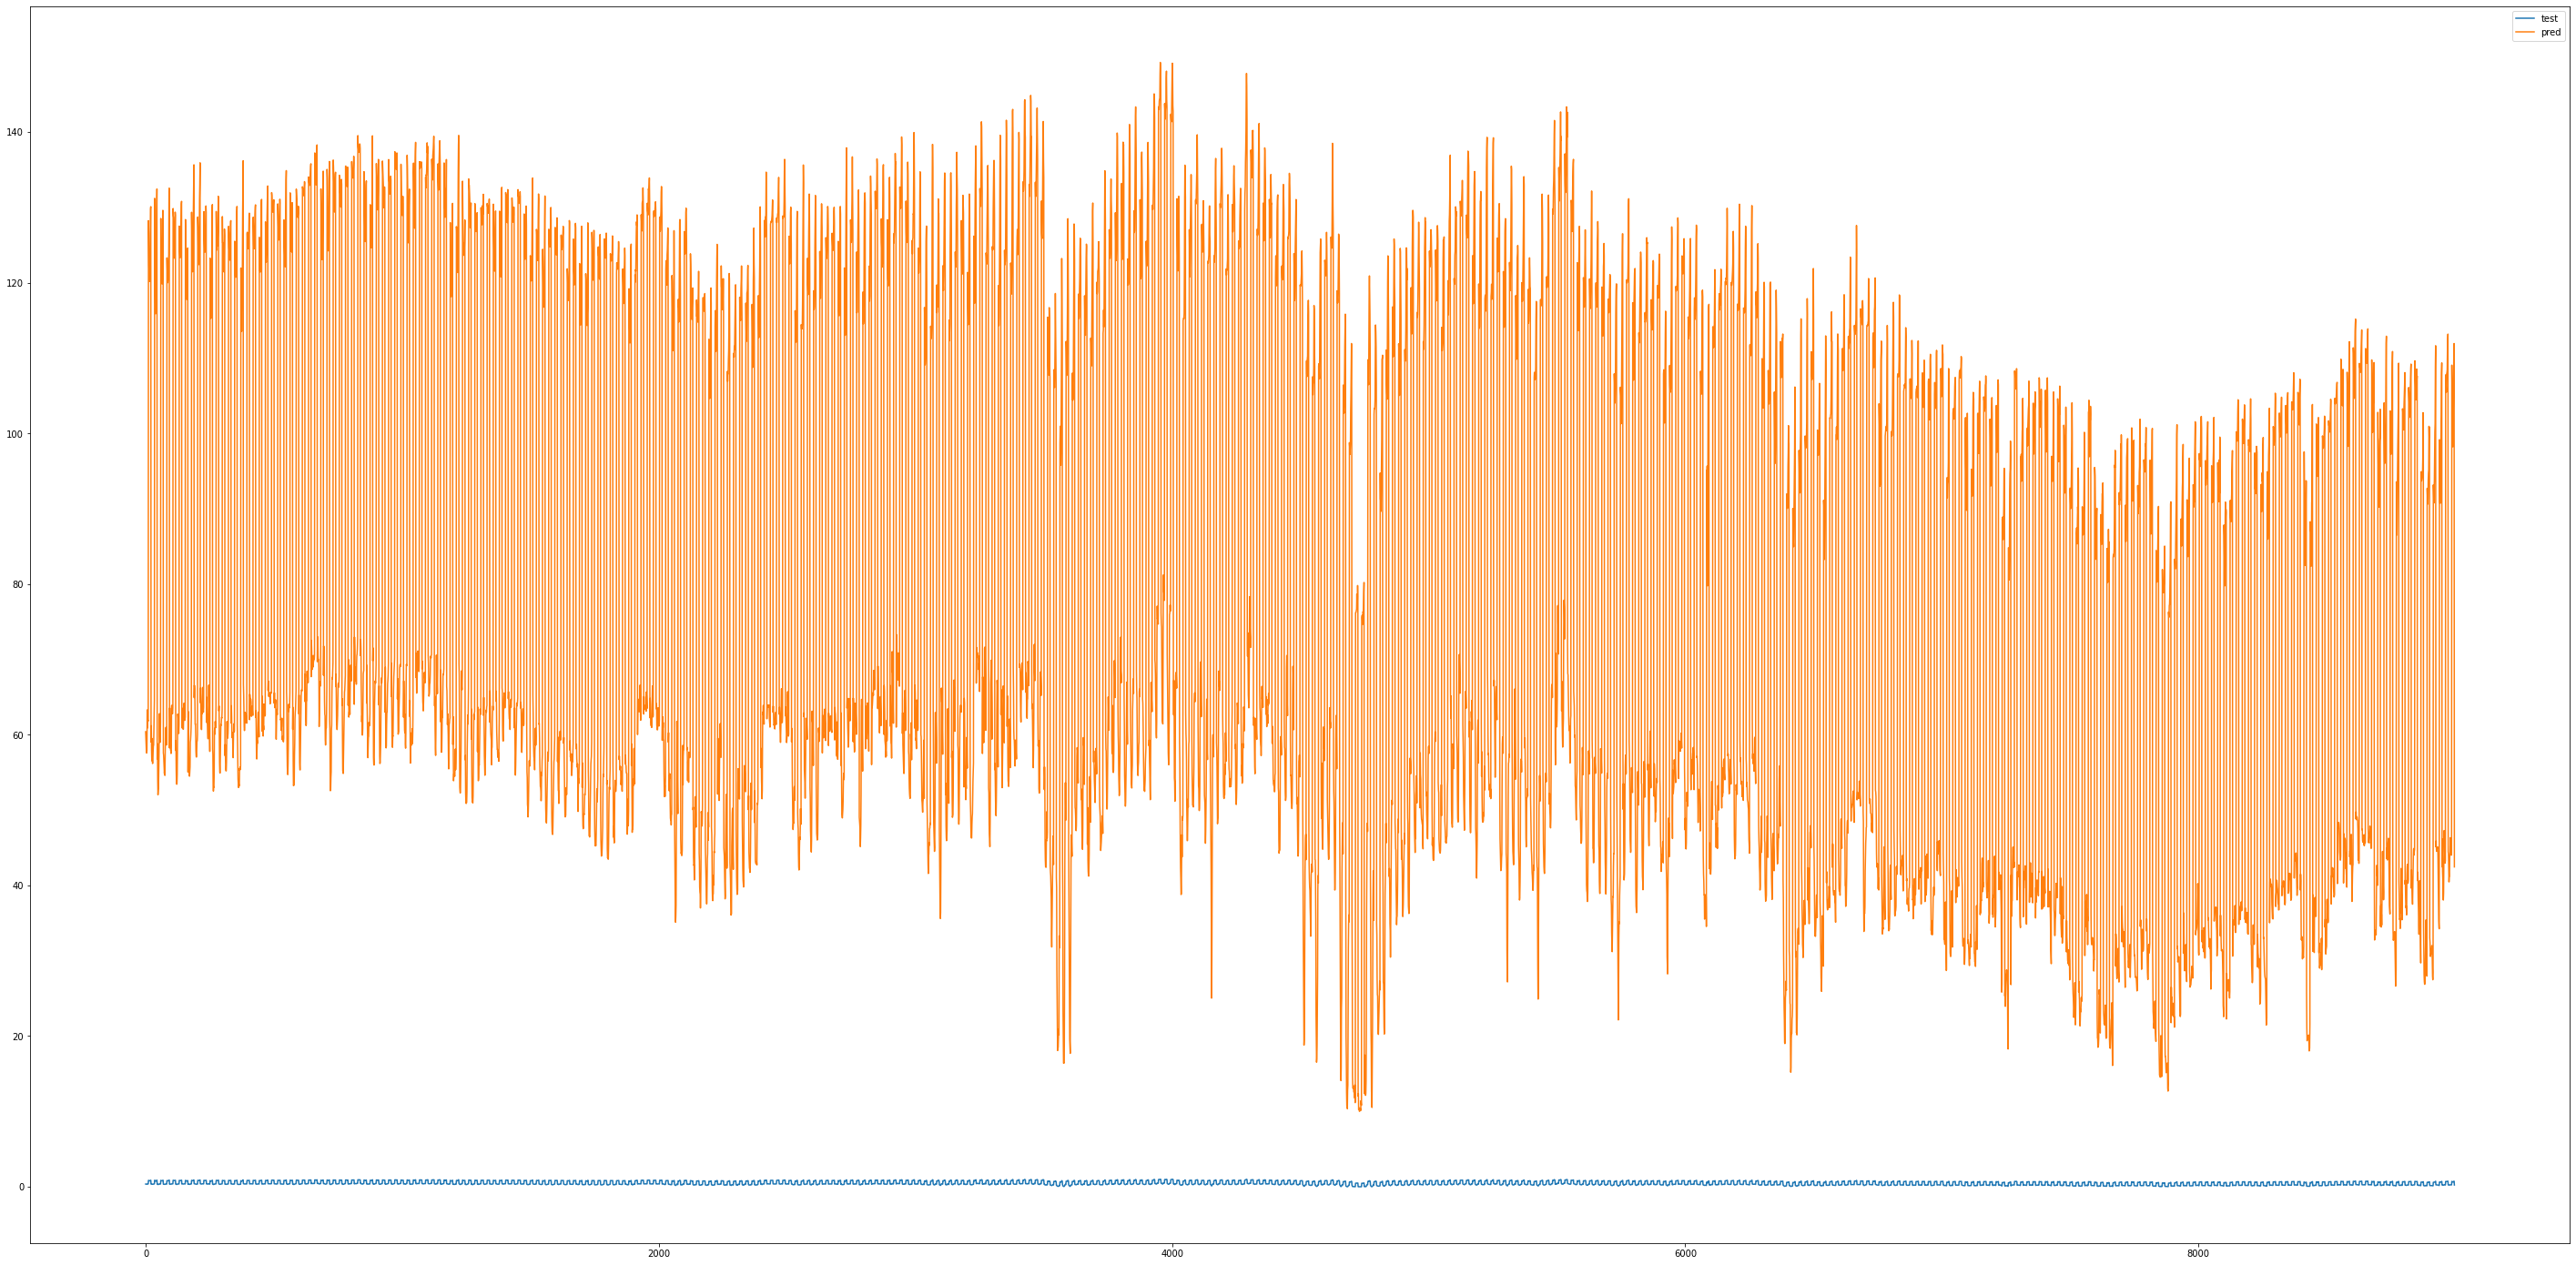

In [16]:
plot_predictions(y_neu,y_pred_neu)